# Experiment 1: Acquiring time-domain IQ data following the flux curve and varying the clearing tone frequency and power

**Goal:**

Get `release_rates(clearing_tone_freq, clearing_tone_power)`

**Method:**

- Vary phi, find f(phi), set drive tone to f(phi)
- Vary clearing tone and clearing power and record I,Q data
- Run HMM analysis on the recorded data to get the rates




In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import os
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from scipy.optimize import curve_fit, minimize, Bounds, dual_annealing
from time import perf_counter, sleep
import pickle
import logging
from tqdm import tqdm

In [ ]:
import fitTools.quasiparticleFunctions as qp
from fitTools.utilities import dBm2Watt, Watt2dBm
from srsinst.dc205 import DC205
import Labber
from VISAdrivers.continuousAlazar import ADC

In [3]:
from utils import *
from flux_fit import *

## Setting up the Experiment


### Variables and Constants

In [ ]:
project_name = "Andreev_Spectroscopy"
device_name = "L1A"
T_MXC = 26
T_Rad = 1.8
experiment_name = f"{device_name}_test"

drive_path = r"G:\Shared drives\Quasiparticles_2"
data_path = set_project(r"{}\{}".format(drive_path, project_name), f"{experiment_name}")

# Constants
SPATH = data_path
FIG_PATH = os.path.join(SPATH, "Figures")
LOG_FILE = os.path.join(SPATH, f'MEASUREMENTLOG_{time.strftime("%Y%m%d_%H%M%S")}.log')
PATH_TO_EXE = r'C:/Users/LFL/lflPython/AlazarDrivers/CS_Average/x64/Release/ATS9371_CS_Average.exe'

# Ensure directories exist
os.makedirs(FIG_PATH, exist_ok=True)

# Setup logging
logging.basicConfig(filename=LOG_FILE, filemode='w', level=logging.INFO)


The best fit parameters from the flux fit curve - "G:\Shared drives\Labber\Data\2025\03\Data_03016\NBRL1A_flux_sweep_25mK.hdf5"

In [4]:
best_fit = {'w0': 5.781696425756177,
 'q0': 0.02019771764678007,
 'V_period': -53.166666666666664,
 'V_offset': 1.0000000000000036,
 'error': 0.00011195976902623324}

some test

In [22]:
print(voltage_to_flux_quanta(-24,best_fit))
print(flux_quanta_to_frequency(0.47, best_fit))
print(find_mapped_resonance(0.47, best_fit))
print(phi_to_voltage(0.47, best_fit, unit='V'))

0.4702194357366772
5.711812537542725
5.711812537542725
-0.0023988333333333327


In [23]:
-2.3E-3

-0.0023

Setting up the phi's and getting the required voltage array with the detuning for the drive tone.

From Eli

"Start ~500 MHz above the resonator and go up to 18 GHz (bandwidth limit of SMA cables). Power, start ~ 5 dB below where you get resonance suppression, maybe go down to 20 dB lower"

In [12]:
phi_low, phi_high = 0, 0.1
num_points = 2
phi_arr = np.linspace(phi_low, phi_high, num_points)

In [17]:
v_arr, f_arr = from_flux_fit(phi_arr, best_fit) # mV, GHz

[autoreload of utils failed: Traceback (most recent call last):
  File "/Users/shanto/anaconda3/envs/lfl_tools/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/shanto/anaconda3/envs/lfl_tools/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/shanto/anaconda3/envs/lfl_tools/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/shanto/LFL/QPs/QP_NBR_Experiments/utils.py", line 8, in <module>
    import fitTools.quasiparticleFunctions as qp
ModuleNotFoundError: No module named 'fitTools'
]


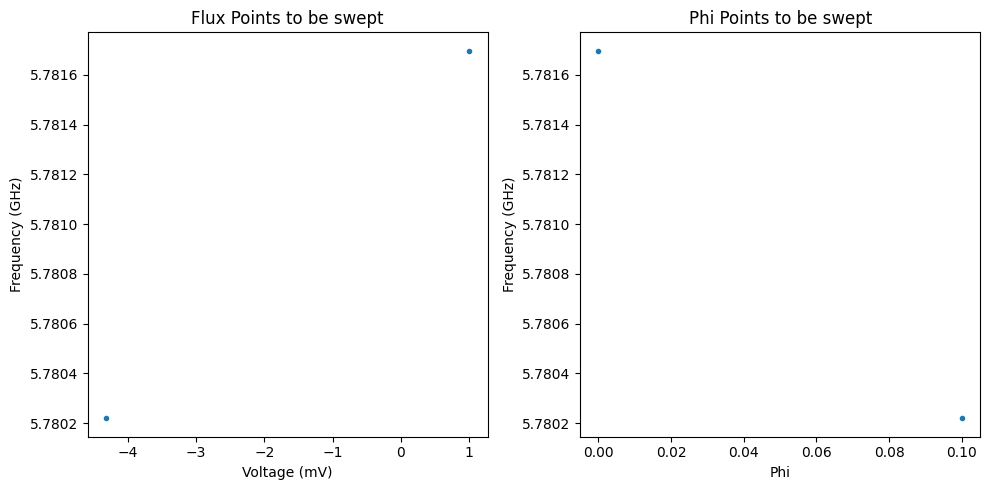

In [18]:
plot_sweep_points(v_arr, f_arr, phi_arr)

### Instrument Setup

In [ ]:
client = Labber.connectToServer(timeout=None)
instrument_list = client.getListOfInstruments()
instruments = create_instrument_connections(client, instrument_list)

The labber instrument server config is saved as a hdf5 file in this repository. Instantiating the instruments we need now.

In [ ]:
vs = connect_SRS()
VNA = instruments['Agilent Network Analyzer E5071B']
DA = instruments['Vaunix Lab Brick Digital Attenuator']
SMU = instruments['Keithley 2400 SourceMeter']
LO= instruments['SignalCore SC5511A Signal Generator_10002F25']
Drive= instruments['SignalCore SC5511A Signal Generator_1000334C']

In [ ]:
# VNA + LO Drive
span = 10e6 # Hz
electrical_delay = 82.584e-9 # s
vna_power = 5
vna_avg = 5
f_d_power = 16

# Clearing
f_low, f_high = 5, 17
f_step = 1
f_clearing_arr = np.arange(f_low, f_high+f_step, f_step)

P_low, P_high = -10, 17
P_step = 1
P_clearing_arr = np.arange(P_low, P_high+P_step, P_step)

In [ ]:
num_traces=1
acquisitionLength_sec=5
origRateMHz=300
sampleRateMHz=10
averageTimeCycle=0
lowerBound=12 # dB for DA attenuator
upperBound=40 # dB for DA attenuator

## The driver code

In [ ]:
# Create a log file for the VNA data
lfVNA = Labber.createLogFile_ForData(f'{device_name}_flux_sweep',
                                      [{'name':f'{VNA.name} - S21','complex':True,'vector':True,'x_name':'Frequency','x_unit':'Hz'}],
                                      step_channels=[{'name':'Phi','values':phi_arr,'unit':'flux quanta'}])

In [ ]:
# test
f_clearing_arr = [5,16]
P_clearing_arr = [-10,15]

for phi in phi_arr:
    voltage = phi_to_voltage(phi, best_fit, unit='V')
    # set_flux_bias_srs(voltage, step = 5e-5)
    print(f"phi: {phi:.6f}, voltage: {voltage:.6f} V")
    f_phi, f_drive = find_resonance(phi, span, best_fit, vna_power, vna_avg, electrical_delay)
    print(f"f_phi: {f_phi:.6f} GHz, f_drive: {f_drive:.6f} GHz")
    # set_drive_tone(f_drive, f_d_power)

    for f_clearing in f_clearing_arr:
        for P_clearing in P_clearing_arr:
            print(f"f_clearing: {f_clearing:.6f} GHz, P_clearing: {P_clearing:.6f} dBm")
            # set_clearing_tone(f_clearing, P_clearing)
            logging.info(f'\nStarting Alazar acquisition at phi = {phi:.3f} while driving at {f_drive:.6f} GHz')
            # savefile = acquire_IQ_data(phi, num_traces, acquisitionLength_sec, origRateMHz, sampleRateMHz, averageTimeCycle, lowerBound, upperBound)
            # write_metadata(savefile, acquisitionLength_sec, origRateMHz, f_drive, voltage, T_MXC, T_Rad, phi, f_clearing, P_clearing)
            sleep(0.5)